In [1]:
import torch
import library
import sindy
from neuromancer import psl
from torch.utils.data import DataLoader
from matplotlib.lines import Line2D
from neuromancer.system import Node, System
from neuromancer.dynamics import integrators
from neuromancer.trainer import Trainer
from neuromancer.problem import Problem
from neuromancer.loggers import BasicLogger
from neuromancer.dataset import DictDataset
from neuromancer.constraint import variable
from neuromancer.loss import PenaltyLoss
from neuromancer.modules import blocks
from neuromancer.plot import pltOL
import matplotlib.pyplot as plt
torch.manual_seed(0)
# For now, we use CPU till we fix the cuda utilization error
dev = torch.device("cpu" if torch.cuda.is_available() else "cpu")


### Plotting Open Loop System

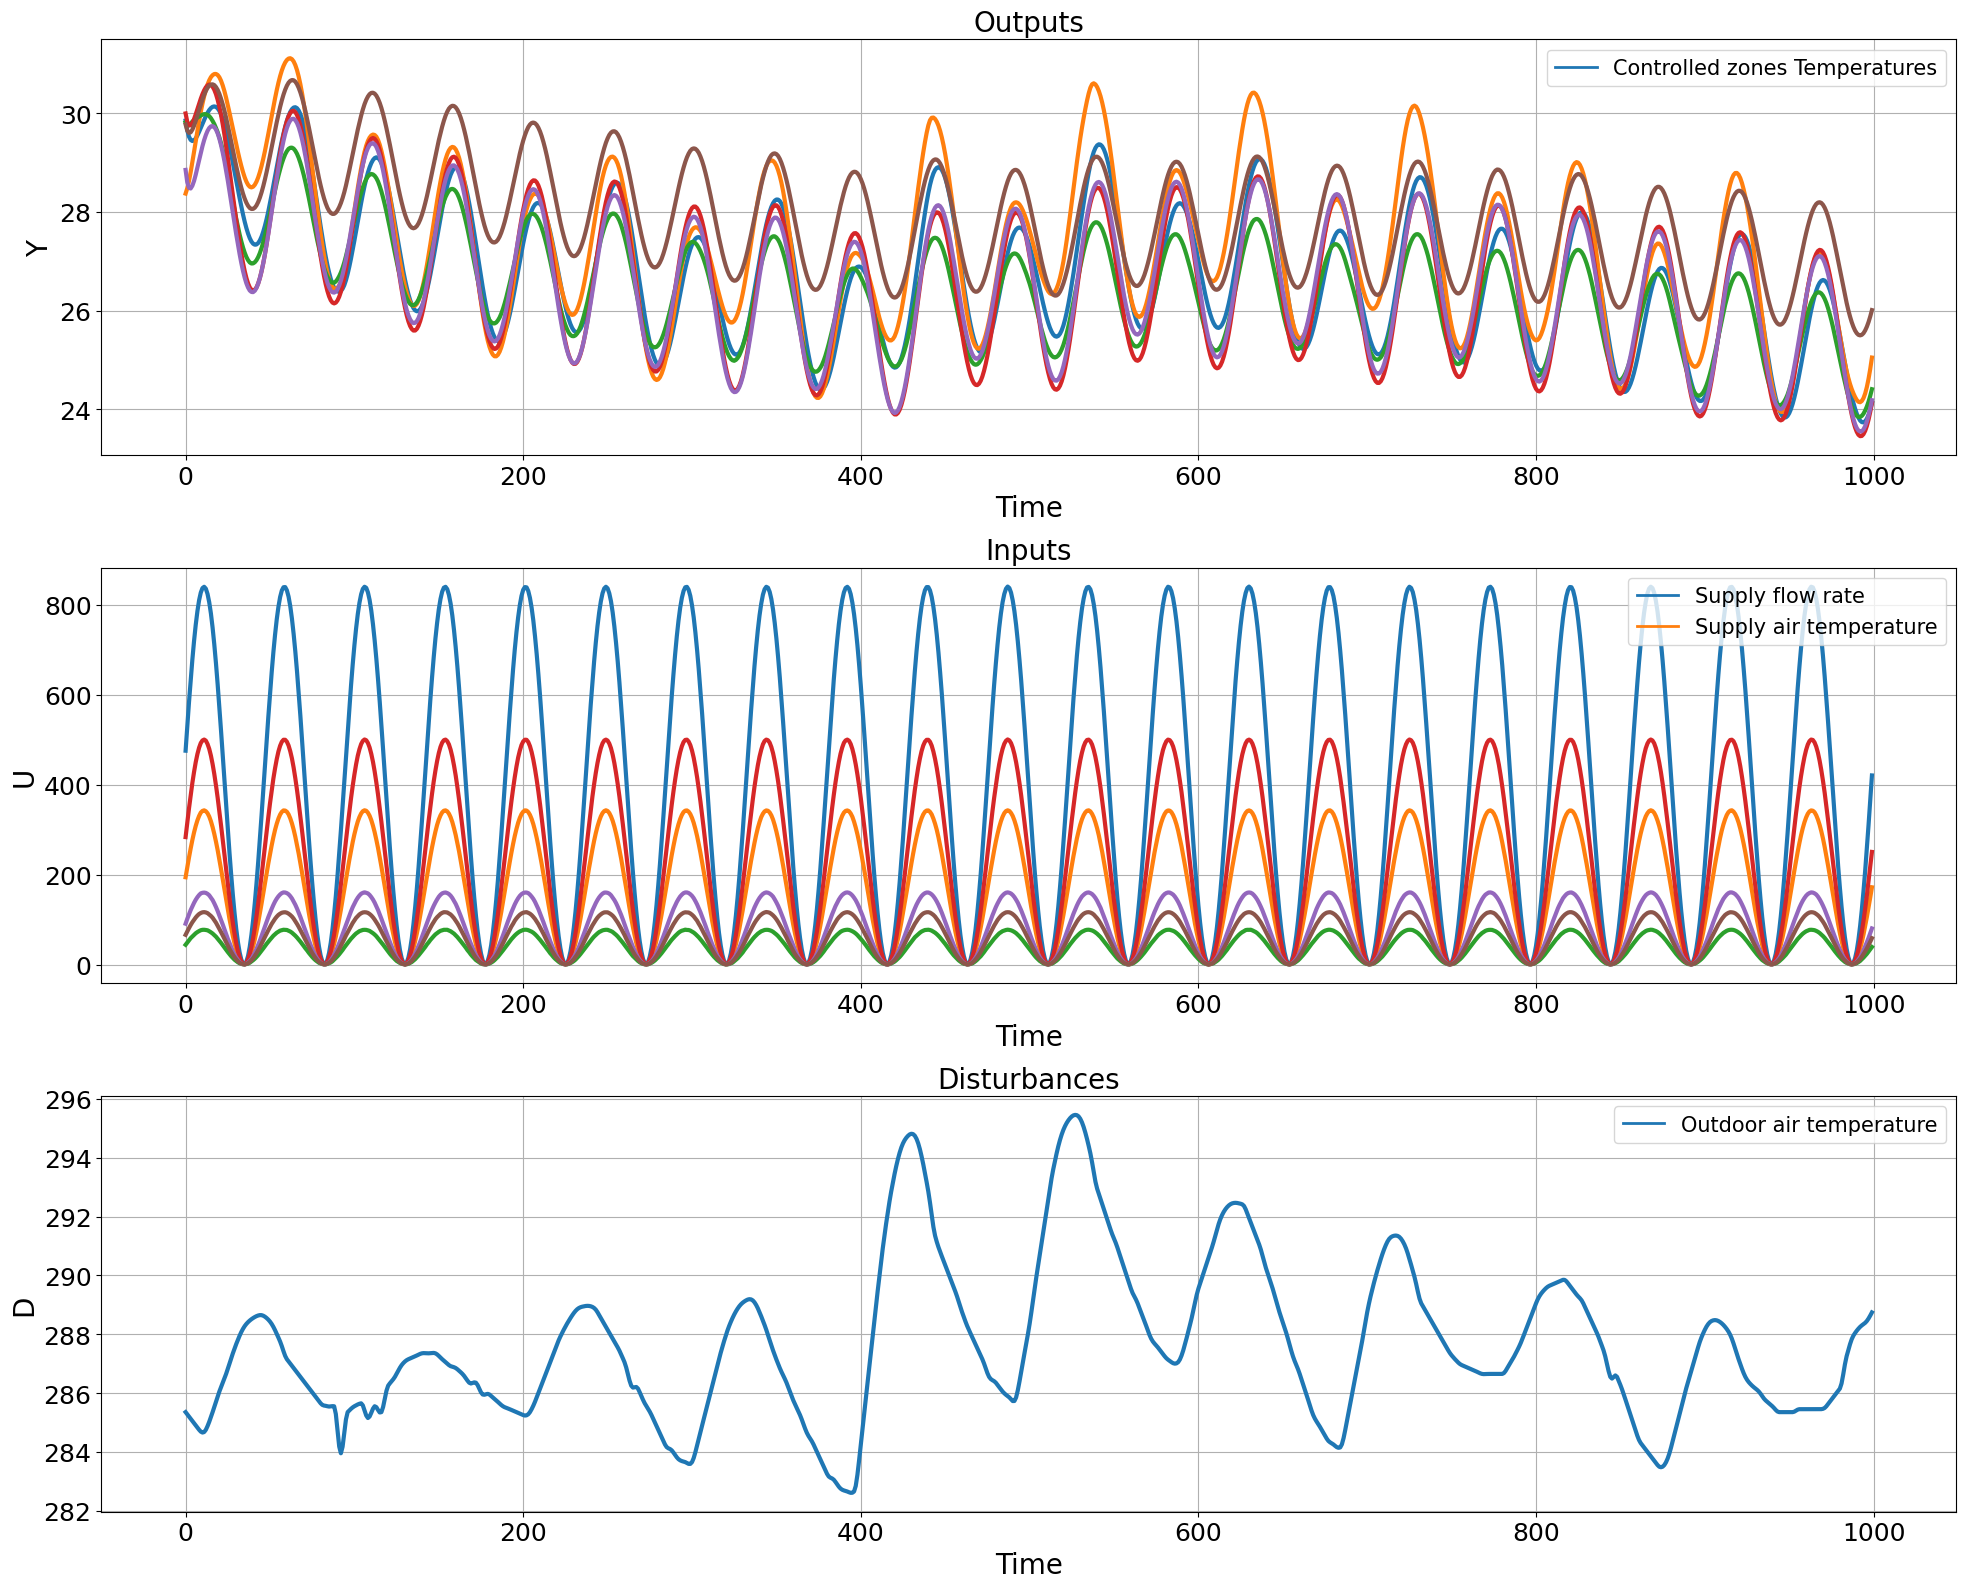

In [2]:
gt_model_name = "LinearReno_ROM40"
gt_model = psl.systems[gt_model_name]()

ts = gt_model.ts
nx = gt_model.nx
ny = gt_model.ny
nu = gt_model.nu
nd = gt_model.nd

raw = gt_model.simulate(nsim=1000)
fig, ax = pltOL(Y=raw['Y'], U=raw['U'], D=raw['D'])
# add custom legends to plots
custom_lines_1 = [Line2D([0], [0], color='tab:blue', lw=2, linestyle='-')]
custom_lines_2 = [Line2D([0], [0], color='tab:blue', lw=2, linestyle='-'),
                    Line2D([0], [0], color='tab:orange', lw=2, linestyle='-')]
ax[0, 0].legend(custom_lines_1, ['Controlled zones Temperatures'], fontsize=15, loc="best")
ax[1, 0].legend(custom_lines_2, ['Supply flow rate', 'Supply air temperature'], fontsize=15, loc="best")
ax[2, 0].legend(custom_lines_1, ['Outdoor air temperature'], fontsize=15, loc="best")

### Getting the Training Data

In [3]:

def get_data(gt_model, nsim, nsteps, ts):
    """
    :param nsteps: (int) Number of timesteps for each batch of training data
    :param sys: (psl.system)
    :param ts: (float) step size

    """
    sim = gt_model.simulate(nsim=nsim, ts=ts)
    nx = gt_model.nx
    nu = gt_model.nu
    nd = gt_model.nd
    ny = gt_model.ny
    nbatch = nsim//nsteps
    length = (nsim//nsteps) * nsteps

    def normalize(x, mean, std):
        return (x - mean) / std

    X = normalize(sim['X'][:length], gt_model.stats['X']['mean'], gt_model.stats['X']['std'])
    X = torch.Tensor(X).reshape(nbatch, nsteps, nx)
    Y = normalize(sim['Y'][:length], gt_model.stats['Y']['mean'], gt_model.stats['Y']['std'])
    Y = torch.Tensor(Y).reshape(nbatch, nsteps, ny)
    U = normalize(sim['U'][:length], gt_model.stats['U']['mean'], gt_model.stats['U']['std'])
    U = torch.Tensor(U).reshape(nbatch, nsteps, nu)
    D = normalize(sim['D'][:length], gt_model.stats['D']['mean'], gt_model.stats['D']['std'])
    D = torch.Tensor(D).reshape(nbatch, nsteps, nd)

    return {"X": X, "yn": Y[:,:1], "Y": Y, "U": U, "D": D}

def get_splits(sys, nsim, nsteps, ts, bs):
    """
    :param nsteps: (int) Number of timesteps for each batch of training data
    :param sys: (psl.system)
    :param ts: (float) step size
    :param bs: (int) batch size
    """
    train_data, dev_data = [get_data(sys, nsim, nsteps, ts) for _ in range(2)]

    train_data = DictDataset(train_data, name="train")
    train_loader = DataLoader(train_data, batch_size=bs, collate_fn=train_data.collate_fn, shuffle=True)

    dev_data = DictDataset(dev_data, name="dev")
    dev_loader = DataLoader(dev_data, batch_size=bs, collate_fn=dev_data.collate_fn, shuffle=True)

    test_data = get_data(sys, nsim, nsim, ts)
    test_data["name"] = "test"

    return train_loader, dev_loader, test_data

In [110]:
nsim = 2000   # number of simulation steps in the dataset
nsteps = 2   # number of prediction horizon steps in the loss function
bs = 128       # minibatching batch size
ts = gt_model.ts
train_loader, dev_loader, test_data = get_splits(gt_model, nsim, nsteps, ts, bs)

### Function Libraries

In [168]:
max_degree = 1
max_freq = 3
p=1
theta_1 = library.FourierLibrary(ny, nu+nd, max_freq=max_freq, include_cos=True)
theta_2 = library.PolynomialLibrary(ny, nu+nd, max_degree=max_degree, interaction=True)
theta_3_funs = [lambda X, u: torch.sin(X[:,0]) * torch.pow(torch.e,X[:,0]), lambda X, u: torch.sin(X[:,1]) * torch.pow(torch.e,X[:,1]),lambda X, u: torch.sin(X[:,2]) * torch.pow(torch.e,X[:,2]),
                lambda X, u: torch.sin(X[:,3]) * torch.pow(torch.e,X[:,3]), lambda X, u: torch.sin(X[:,4]) * torch.pow(torch.e,X[:,4]),lambda X, u: torch.sin(X[:,5]) * torch.pow(torch.e,X[:,5])]
theta_3_names = ["e(x_0)", "e(x_1)","e(x_2)","e(x_3)","e(x_4)","e(x_5)"]
theta_3 = library.FunctionLibrary(theta_3_funs, ny, nu+nd, theta_3_names)

fx = sindy.SINDy(library.CombinedLibrary([theta_1, theta_2, theta_3]))
print(fx)

dx0/dt = 0.148*sin(1*x0) + 0.596*sin(2*x0) + 0.095*sin(3*x0) + 0.353*sin(1*x1) + 0.593*sin(2*x1) + 0.060*sin(3*x1) + 0.755*sin(1*x2) + 0.631*sin(2*x2) + 0.850*sin(3*x2) + 0.565*sin(1*x3) + 0.404*sin(2*x3) + 0.251*sin(3*x3) + 0.413*sin(1*x4) + 0.722*sin(2*x4) + 0.437*sin(3*x4) + 0.227*sin(1*x5) + 0.811*sin(2*x5) + 0.101*sin(3*x5) + 0.504*sin(1*u0) + 0.553*sin(2*u0) + 0.176*sin(3*u0) + 0.159*sin(1*u1) + 0.316*sin(2*u1) + 0.763*sin(3*u1) + 0.220*sin(1*u2) + 0.417*sin(2*u2) + 0.234*sin(3*u2) + 0.612*sin(1*u3) + 0.582*sin(2*u3) + 0.044*sin(3*u3) + 0.472*sin(1*u4) + 0.651*sin(2*u4) + 0.848*sin(3*u4) + 0.785*sin(1*u5) + 0.216*sin(2*u5) + 0.167*sin(3*u5) + 0.045*sin(1*u6) + 0.373*sin(2*u6) + 0.987*sin(3*u6) + 0.675*cos(1*x0) + 0.911*cos(2*x0) + 0.391*cos(3*x0) + 0.521*cos(1*x1) + 0.021*cos(2*x1) + 0.995*cos(3*x1) + 0.548*cos(1*x2) + 0.477*cos(2*x2) + 0.746*cos(3*x2) + 0.674*cos(1*x3) + 0.786*cos(2*x3) + 0.278*cos(3*x3) + 0.728*cos(2*x4) + 0.942*cos(3*x4) + 0.287*cos(1*x5) + 0.581*cos(2*x5) + 0

### Creating the Nodes and System

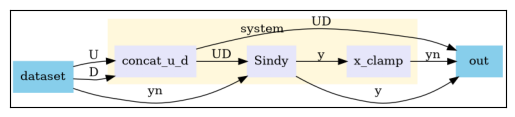

In [169]:
integrator = integrators.Euler(fx, h=ts)
combined_ud = Node(lambda u, d: torch.cat([u, d], dim=-1),
              ['U', 'D'], ['UD'], name="concat_u_d")

integrator_node = Node(integrator, ['yn', 'UD'], ['y'], name="Sindy")
x_bound = Node(lambda x: torch.clamp(x, 0., 1.), ['y'], ['yn'], "x_clamp")
dynamics_model = System([combined_ud, integrator_node, x_bound], nsteps=nsteps, name="dynamics_model")
dynamics_model.show()


### Neural ODE

In [170]:
# #NODE:
# 
# n_latent = 4  # latent state space dimension
# 
# # latent state estimator
# encoder = blocks.MLP(ny, n_latent, bias=True,
#                 linear_map=torch.nn.Linear,
#                 nonlin=torch.nn.ReLU,
#                 hsizes=[64, 64])
# encode_sym = Node(encoder, ['yn'], ['xn'], name='encoder')
# 
# 
# 
# # construct latent NODE model in Neuromancer
# fx = blocks.MLP(n_latent+nu+nd, n_latent, bias=True,
#                     linear_map=torch.nn.Linear,
#                     nonlin=torch.nn.Tanh,
#                     hsizes=[128, 128])
# 
# 
# # integrate NODE with adjoint-based solver
# fxRK4 = integrators.RK4(fx, h=ts)
# model = Node(fxRK4, ['xn', 'U', 'D'], ['xn'], name='NODE')
# 
# # latent output model
# decoder = blocks.MLP(n_latent, ny, bias=True,
#                 linear_map=torch.nn.Linear,
#                 nonlin=torch.nn.ReLU,
#                 hsizes=[64, 64])
# decode_sym = Node(decoder, ['xn'], ['y'], name='decoder')
# 
# # latent NODE rollout
# dynamics_model = System([model, decode_sym], name='system', nsteps=nsteps)


In [171]:
# %% Constraints + losses:
x = variable("Y")
xhat = variable('yn')[:, :-1, :]

# one step loss
onestep_loss = 1.*(xhat[:, 1, :] == x[:, 1, :])^2
onestep_loss.name = "onestep_loss"

# reference tracking loss
reference_loss = 10. * ((xhat == x)^2)
reference_loss.name = "ref_loss"

#sparsity
l1 = variable([x], lambda y: torch.norm(list(fx.parameters())[0], p))
loss_l1 = 0.000001*(l1 == 0)

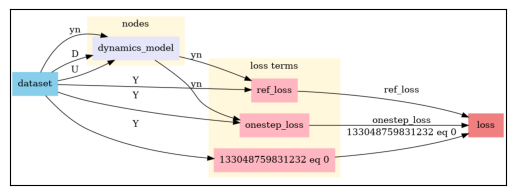

In [172]:

# putting things together
objectives = [reference_loss, onestep_loss, loss_l1]
constraints = []
#nodes = [encode_sym, dynamics_model]
# create constrained optimization loss
loss = PenaltyLoss(objectives, constraints)

# construct constrained optimization problem
problem = Problem([dynamics_model], loss)
# plot computational graph
problem.show()

### Training the SINDy Model

In [173]:
optimizer = torch.optim.Adam(problem.parameters(),
                                lr=.001)
logger = BasicLogger(args=None, savedir='test', verbosity=1,
                        stdout=['dev_loss', 'train_loss'])

trainer = Trainer(
    problem,
    train_loader,
    dev_loader,
    test_data,
    optimizer,
    patience=1000,
    warmup=1000,
    epochs=5000,
    eval_metric="dev_loss",
    train_metric="train_loss",
    dev_metric="dev_loss",
    test_metric="dev_loss",
    logger=logger,
)


None
Number of parameters: 588


In [174]:
# %% train
best_model = trainer.train()
problem.load_state_dict(best_model)


epoch: 0	train_loss: 1.63137	dev_loss: 4.39741	eltime:  2.16328
epoch: 1	train_loss: 1.66919	dev_loss: 4.01799	eltime:  2.28230
epoch: 2	train_loss: 1.42387	dev_loss: 4.74857	eltime:  2.42263
epoch: 3	train_loss: 1.75614	dev_loss: 5.06145	eltime:  2.57534
epoch: 4	train_loss: 1.66398	dev_loss: 4.60282	eltime:  2.70064
epoch: 5	train_loss: 2.23613	dev_loss: 4.06624	eltime:  2.81686
epoch: 6	train_loss: 1.63278	dev_loss: 5.12659	eltime:  2.93943
epoch: 7	train_loss: 1.95512	dev_loss: 4.55896	eltime:  3.05524
epoch: 8	train_loss: 2.25413	dev_loss: 4.05876	eltime:  3.17347
epoch: 9	train_loss: 1.90129	dev_loss: 4.69427	eltime:  3.29195
epoch: 10	train_loss: 1.50987	dev_loss: 4.81172	eltime:  3.42489
epoch: 11	train_loss: 1.22855	dev_loss: 3.41961	eltime:  3.55748
epoch: 12	train_loss: 1.79602	dev_loss: 4.63702	eltime:  3.67663
epoch: 13	train_loss: 1.35761	dev_loss: 4.03690	eltime:  3.79395
epoch: 14	train_loss: 1.81621	dev_loss: 5.08226	eltime:  3.91325
epoch: 15	train_loss: 1.67240	dev_l

<All keys matched successfully>

In [175]:
print(fx)

dx0/dt = -0.762*sin(1*x0) + -0.223*sin(2*x0) + -0.481*sin(3*x0) + -0.065*sin(1*x1) + 0.115*sin(2*x1) + -0.333*sin(3*x1) + 0.719*sin(1*x2) + 0.546*sin(2*x2) + 0.632*sin(3*x2) + -0.236*sin(1*x3) + -0.284*sin(2*x3) + -0.252*sin(3*x3) + 0.333*sin(2*x4) + 0.126*sin(3*x4) + 0.047*sin(1*x5) + 0.709*sin(2*x5) + 0.220*sin(3*x5) + 0.519*sin(1*u0) + 0.190*sin(2*u0) + -0.221*sin(3*u0) + 0.174*sin(1*u1) + 0.210*sin(3*u1) + 0.240*sin(1*u2) + 0.056*sin(2*u2) + -0.160*sin(3*u2) + 0.627*sin(1*u3) + 0.219*sin(2*u3) + -0.353*sin(3*u3) + 0.485*sin(1*u4) + 0.287*sin(2*u4) + 0.298*sin(3*u4) + 0.803*sin(1*u5) + -0.230*sin(3*u5) + 1.528*sin(1*u6) + 0.327*sin(2*u6) + -0.114*sin(3*u6) + 0.146*cos(1*x0) + 0.719*cos(2*x0) + 1.050*cos(3*x0) + -0.081*cos(1*x1) + -0.638*cos(2*x1) + 0.053*cos(3*x1) + -0.130*cos(1*x2) + -0.522*cos(2*x2) + -0.923*cos(3*x2) + 0.115*cos(1*x3) + 0.397*cos(2*x3) + 0.161*cos(3*x3) + -0.581*cos(1*x4) + 0.077*cos(2*x4) + 0.155*cos(3*x4) + -0.305*cos(1*x5) + -0.082*cos(2*x5) + -0.136*cos(3*x5)

In [176]:
# # Curriculum Model training
# iterations = 5
# for i in range(iterations):
#     print(f'training {nsteps} objective')
#     best_model = trainer.train()
#     trainer.model.load_state_dict(best_model)
#     print(f'Done training with {nsteps}......')
#     nsteps *= 2  # increase prediction horizon
#     # create dataloaders with batched trajectories using new prediction horizon
#     train_loader, dev_loader, test_data = \
#         get_splits(gt_model, nsim, nsteps, ts, bs)
#     trainer.train_data, trainer.dev_data, trainer.test_data = \
#         train_loader, dev_loader, test_data
#     print(f'Created New Data with {nsteps}......')
#     # reset early stopping
#     trainer.badcount = 0

### Closed Loop System Rollout

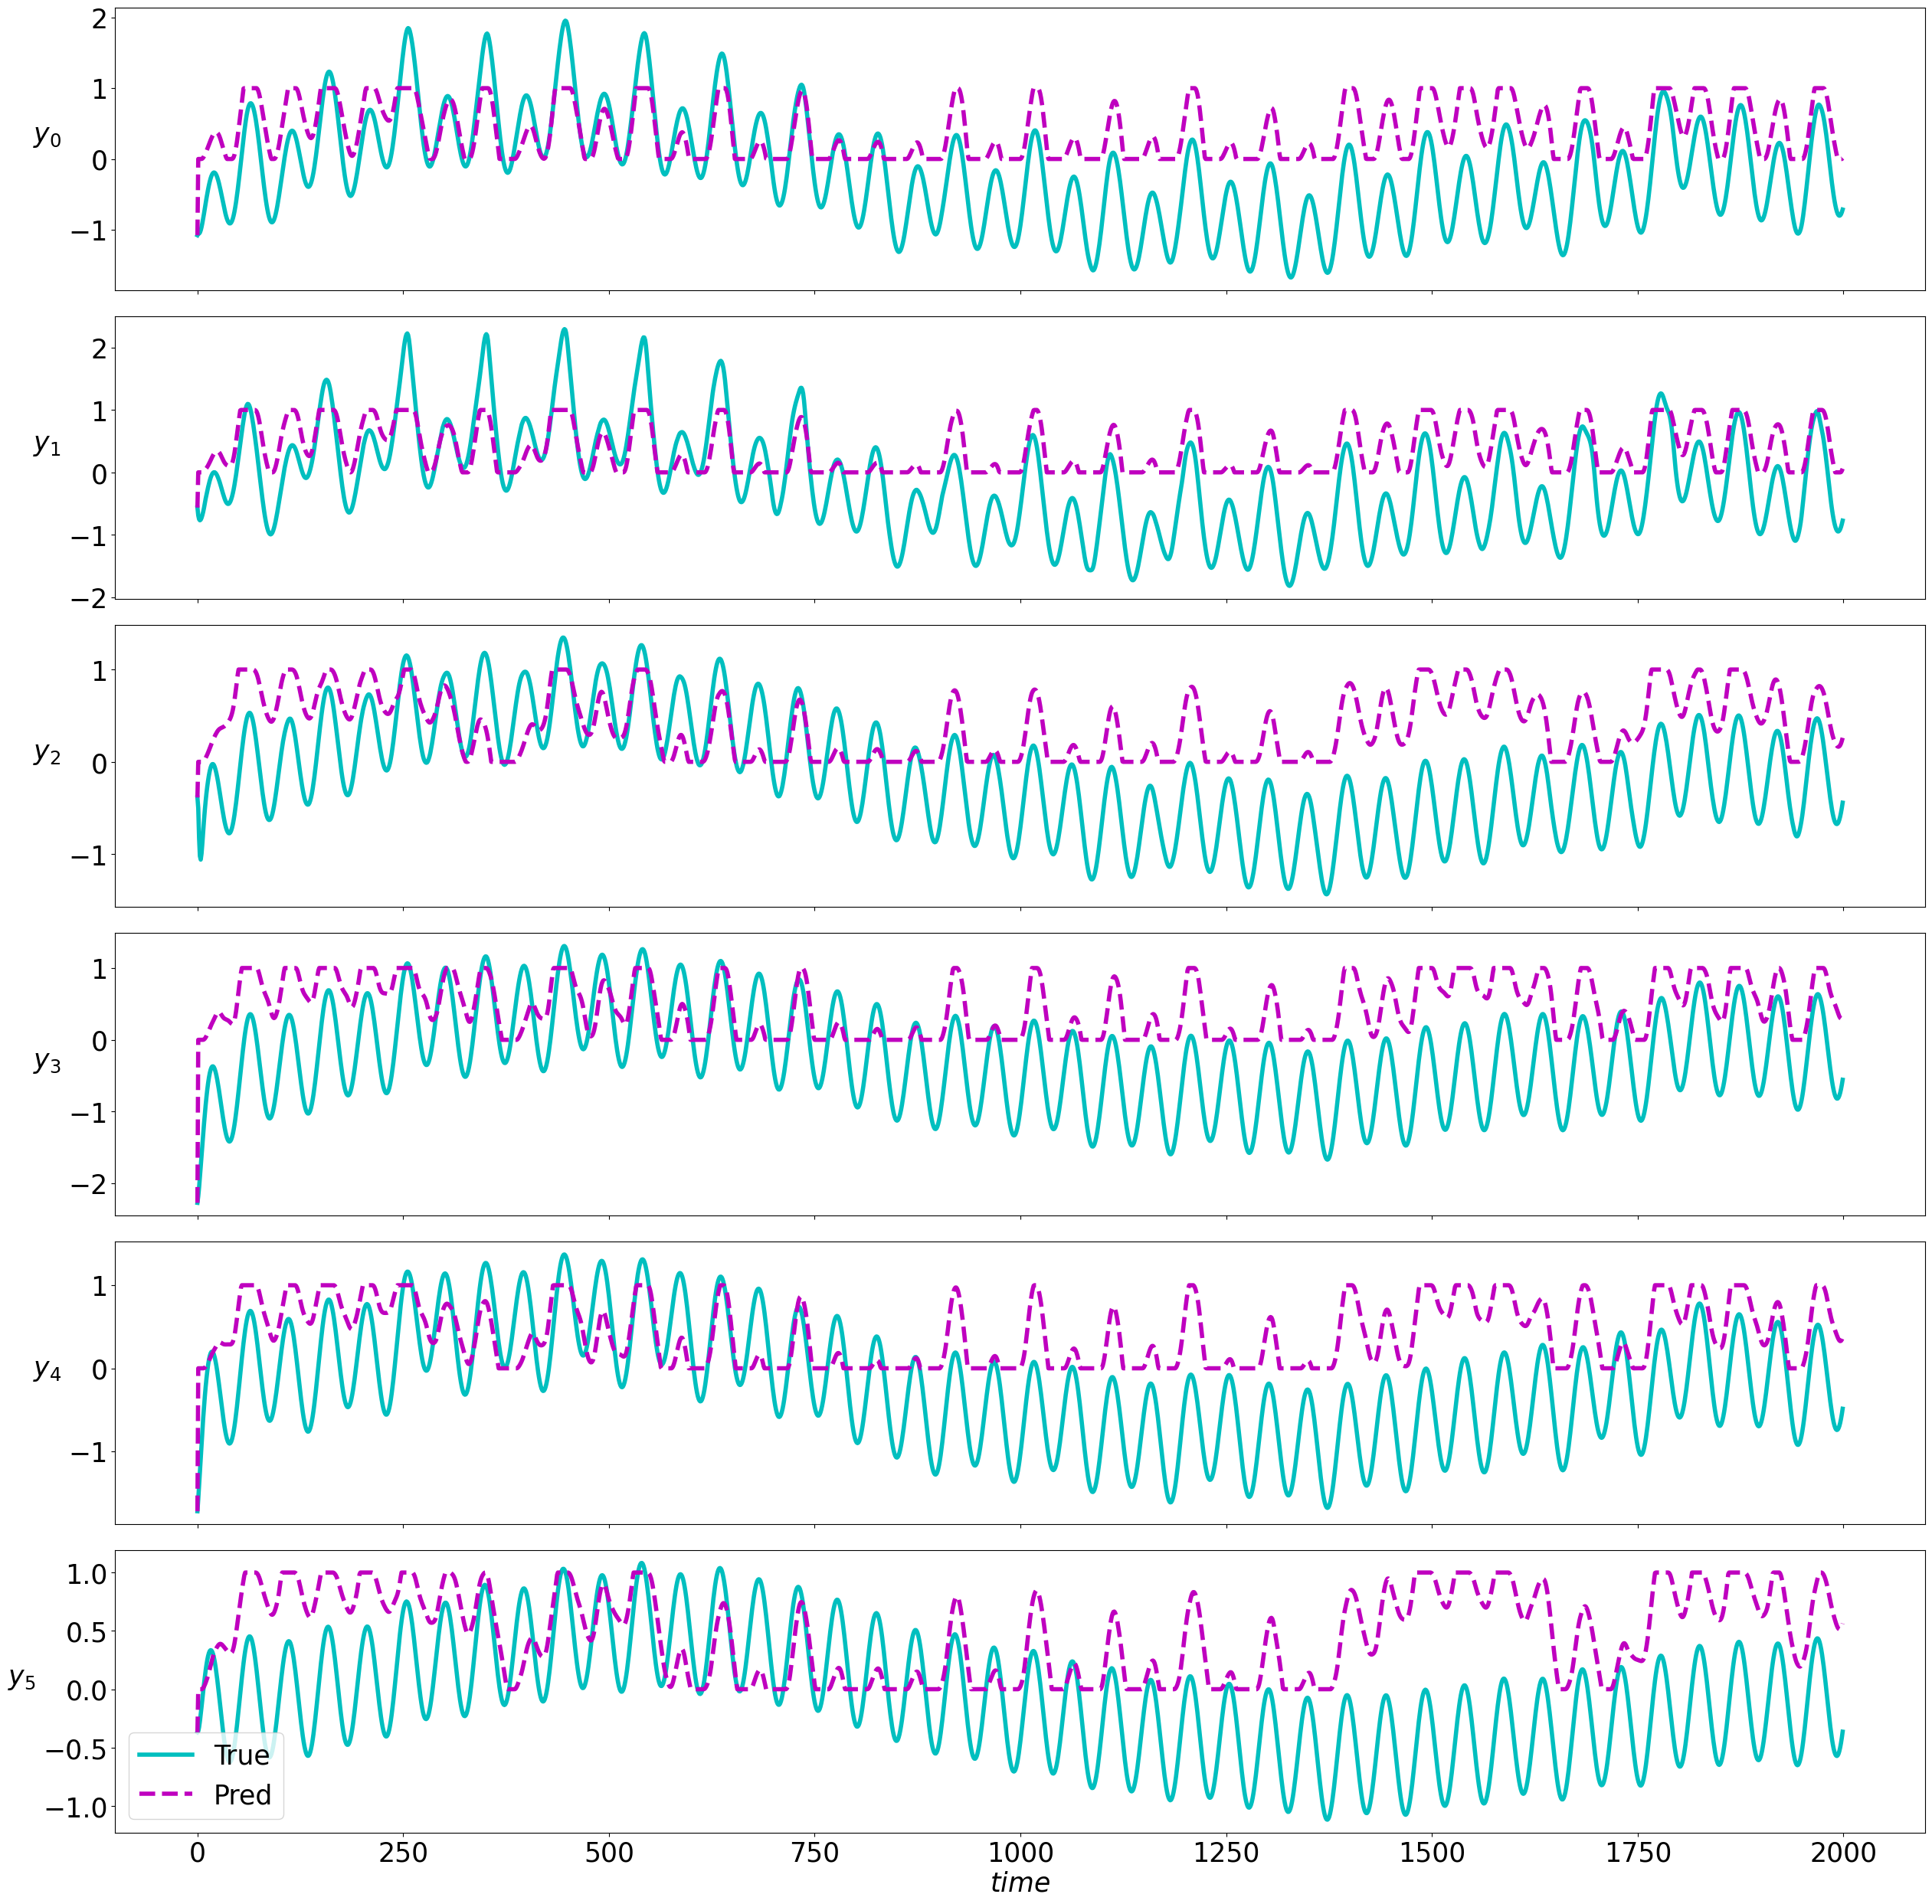

In [177]:
dynamics_model.nsteps = test_data['Y'].shape[1]
test_output = dynamics_model(test_data)

pred_traj = test_output['yn'][:, :-1, :]
true_traj = test_data['Y']
pred_traj = pred_traj.detach().numpy().reshape(-1, ny)
true_traj = true_traj.detach().numpy().reshape(-1, ny)
pred_traj, true_traj = pred_traj.transpose(1, 0), true_traj.transpose(1, 0)

figsize = 25
fig, ax = plt.subplots(ny, figsize=(figsize, figsize))
labels = [f'$y_{k}$' for k in range(len(true_traj))]
for row, (t1, t2, label) in enumerate(zip(true_traj, pred_traj, labels)):
    if ny > 1:
        axe = ax[row]
    else:
        axe = ax
    axe.set_ylabel(label, rotation=0, labelpad=20, fontsize=figsize)
    axe.plot(t1, 'c', linewidth=4.0, label='True')
    axe.plot(t2, 'm--', linewidth=4.0, label='Pred')
    axe.tick_params(labelbottom=False, labelsize=figsize)
axe.tick_params(labelbottom=True, labelsize=figsize)
axe.legend(fontsize=figsize)
axe.set_xlabel('$time$', fontsize=figsize)
plt.tight_layout()

## FOR POLICY ONLY 

In [7]:
torch.manual_seed(0)

n_samples = 3000    # number of sampled scenarios
batch_size = 128
xmin_range = torch.distributions.Uniform(18., 22.)

max_degree = 1
max_freq = 3
sparsity = 0
p = 1

theta_1 = library.FourierLibrary(ny, 2*nref+nd_obs, max_freq=max_freq, include_cos=False)
theta_2 = library.PolynomialLibrary(ny, 2*nref+nd_obs, max_degree=max_degree, interaction=False)
names = ['1', 'y0', 'y1', 'y2', 'y3', 'y4', 'y5',
        'y0_min', 'y1_min', 'y2_min', 'y3_min', 'y4_min', 'y5_min',
        'y0_max', 'y1_max', 'y2_max', 'y3_max', 'y4_max', 'y5_max',
         'd']
theta_2.function_names = names
poly_sindy = sindy.SINDy(theta_2, n_out=nu)  
four_sindy = sindy.SINDy(theta_1, n_out=nu)  



In [8]:
action_weight = 0.1
state_weight = 50.
du_weight = 0.0
u_bound_weight = 1.

def train_func(optim, system, sparsity):
    nsteps = system.nsteps
    # variables
    y = variable('y')
    u = variable('u')
    ymin_val = variable('ymin')
    ymax_val = variable('ymax')
    umin_val = variable('umin')
    umax_val = variable('umax')
    
    l = variable([y], lambda y: torch.norm(list(system.parameters())[0], p))

    loss_l = sparsity*((l == 0))
    
    action_loss = action_weight * ((u == 0.0))  # energy minimization
    du_loss = du_weight * (u[:,:-1,:] - u[:,1:,:] == 0.0)  # delta u minimization to prevent agressive changes in control actions
    
    state_lower_bound_penalty = state_weight*(y >= ymin_val)
    state_upper_bound_penalty = state_weight*(y <= ymax_val)

    u_lower_bound_penalty = u_bound_weight*(u >= umin_val)
    u_upper_bound_penalty = u_bound_weight*(u <= umax_val)

    constraints = [state_lower_bound_penalty, state_upper_bound_penalty, u_lower_bound_penalty, u_upper_bound_penalty]
    objectives = [action_loss, loss_l]
    
    components = [system]

    train_loader, dev_loader = [
            get_policy_data(gt_model, nsteps, n_samples, xmin_range, batch_size, name=name)
            for name in ("train", "dev")]   
    loss = PenaltyLoss(objectives, constraints)
    problem = Problem(components, loss)
    trainer = Trainer(
        problem,
        train_loader,
        dev_loader,
        optimizer=optim,
        epochs=350,
        train_metric='train_loss',
        eval_metric='dev_loss',
        patience=300,
        epoch_verbose=1,
        device=dev
    )
    
    # Train control policy
    best_model = trainer.train()
    
    # load best trained model
    trainer.model.load_state_dict(best_model)


    system.nsteps = nsteps
    trainer.badcount = 0



In [9]:
nsteps = 100
u_bound_node = Node(lambda u: torch.clamp(u, umin, umax), ['u_un'], ['u'])
policy_node = Node(poly_sindy,  ['y', 'R'], ['u']).to(dev)
combined_y = Node(lambda ymin, ymax, d: torch.cat([ymin, ymax, d], dim=-1),
              ['ymin', 'ymax', 'd_obs'], ['R'], name="y")
ssm = Node(ssm_forward, ['x', 'u', 'd'], ['x', 'y'])
poly_system = System([dist_obs, combined_y, policy_node, ssm],
                nsteps=nsteps,
                name='sindy_system').to(dev)
optimizer = torch.optim.AdamW(poly_sindy.parameters(), lr=.06)

In [10]:
torch.cuda.empty_cache()


In [11]:
train_func(optimizer, poly_system, sparsity)

/home/alireza/neuromancer/neuromancer/neuromancer_RL/src/neuromancer/constraint.py:169: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([128, 100, 20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.l1_loss(left, right)
/home/alireza/neuromancer/neuromancer/neuromancer_RL/src/neuromancer/constraint.py:169: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([56, 100, 20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.l1_loss(left, right)


epoch: 0  train_loss: 74.56587982177734
epoch: 1  train_loss: 48.33097457885742
epoch: 2  train_loss: 43.516326904296875
epoch: 3  train_loss: 40.559417724609375
epoch: 4  train_loss: 38.071170806884766
epoch: 5  train_loss: 36.034751892089844
epoch: 6  train_loss: 34.37565994262695
epoch: 7  train_loss: 33.025177001953125
Interrupted training loop.
